# Vision Zero, Chicago, modeling car crashes with injuries.

# Overview
I was hired by a government agency CMAP (Chicago Metropolitan Agency for Planning) to create a model which predicts injuries during car crashes based on information collected by Chicago Police Department (CPD). I  concluded that there are many features that determine the oucome of car crash(overall 200 features, only 31 were used in our model), some of them: type of crash , day, season, time, type of crash, are there injuried people, phyesical imparement factors(drugs, alchogol, distraction etc), speed limit, weather, lightning and road conditions etc .

To acheive my goal, I trained more than 100 models and tuned hyperparameters, model types that were used: 
- LogisticRegression
- KNN
- Naive Bayes(different type) 
- DecisionTree
- Random Forest
- ADA Boost
- Gradient boost
- XGB Classifier


# Business Understanding
Our stakeholder wants to understand what factors of crash influence on injury outcome as the last possible outcome. They perfectly understand that car crashes will be happening but they want to reduce the number of injuries because individual health prevails under public mobility. 

# Data

1) Database Traffic Crashes - Crashes. Years: 2017 - now
Provided by City of Chicago

https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if 

2) Database Traffic Crashes - People. Years: 2017 - now
Provided by City of Chicago

https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

3) Database Traffic Crashes - Vehicles. Years: 2017 - now
Provided by City of Chicago  

https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3

##### In my research I used data for 2021 year.

# Metrics
#### Our project will answer following question:
What factors influence injuries?

#### Hypothesis:
H0 - car crashes with injuries are random

HA - There is a significant dependancy between injuries and the features of dataset

#### TP, TN, FP, FN definition
TP - we predict car crash with injury and it actually happened.

TN - we predicted that there is no injury and there was no injury,

FP - We predicted injury but there was no injury in real life

FN - We predicted that there will be no injury but it happened


#### Metrics used  
To compare models we will focus on 2 major metrics:

Accuracy - how good we can predict TP and TN. General metrics that will show model performance.

Recall - Health of people is our priority, we will be focused to minimize FN, so we can consider as much real car crashes with injuries in our model as possible, even if our model mark some car crashes with injuries but there will be no such. From the other side we need consider accuracy.


# Data Understanding
#### Sources of data:
1) Database Traffic Crashes - Crashes. Years: 2017 - now
Covers: Main characteristics of car crash.
Provided by City of Chicago 
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

2) Database Traffic Crashes - People. Years: 2017 - now
Covers: People/drivers involved in car crash.
Provided by City of Chicago 
https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

3) Database Traffic Crashes - Vehicles. Years: 2017 - now
Covers: Vehicles involved in car crash.
Provided by City of Chicago 
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3

#### Main dataset contains the following columns:


# Data Cleaning
### Importing required modules

In [1]:
# Work with data
import pandas as pd
import numpy as np
from scipy import stats as stats

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB, GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score
from xgboost import XGBClassifier

# Keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.regularizers import l2

#Other
import pickle
import time
import gzip
import os, shutil 
from zipfile import ZipFile
import scipy
from PIL import Image
from scipy import ndimage


from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
simplefilter(action='ignore', category= FutureWarning)
simplefilter(action='ignore', category= ConvergenceWarning)
simplefilter(action='ignore', category= FitFailedWarning)
simplefilter(action='ignore', category= UserWarning)





np.random.seed(123)

  




### Data preparation

Below we create three objects representing the existing directories: `data/normal/` as `data_normal_dir` and `data/pneumonia/` as `data_pneumonia_dir`, `data/test/normal/` as `test/normal` and `data/test/pneumonia/` as `test/pneumonia`. We will create a new directory `split/` as `new_dir`, where we will split the dataset in three groups (or three subdirectories): `train`, `test`, and `validation`, each containing `normal` and `pneumonia` subfolders. The final desired structure is represented below: 

![title](images/folder_structure.png)

In [2]:
data_normal_dir = 'data/normal/'
data_pneumonia_dir = 'data/pneumonia/'
new_dir = 'data/split/'
data_test_normal_dir = 'data/test/normal/'
data_test_pneumonia_dir = 'data/test/pneumonia/'

In [3]:
# Train set
imgs_normal = [file for file in os.listdir(data_normal_dir) if file.endswith('.jpeg')]
imgs_pneumonia = [file for file in os.listdir(data_pneumonia_dir) if file.endswith('.jpeg')]
# Test set
imgs_normal_test = [file for file in os.listdir(data_test_normal_dir) if file.endswith('.jpeg')]
imgs_pneumonia_test = [file for file in os.listdir(data_test_pneumonia_dir) if file.endswith('.jpeg')]

In [4]:
os.listdir(data_normal_dir)[0]

'NORMAL-2552119-0002.jpeg'

In [5]:
print("Train set:")
print('There are', len(imgs_normal), 'normal images, image name example,',os.listdir(data_normal_dir)[0])
print('There are', len(imgs_pneumonia), 'pneumonia images, image name example,',os.listdir(data_pneumonia_dir)[0])
print("Test set:")
print('There are', len(imgs_normal_test), 'normal images, image name example,',os.listdir(data_test_normal_dir)[0])
print('There are', len(imgs_pneumonia_test), 'pneumonia images, image name example,',os.listdir(data_test_pneumonia_dir)[0])


Train set:
There are 1349 normal images, image name example, NORMAL-2552119-0002.jpeg
There are 4489 pneumonia images, image name example, BACTERIA-4038442-0001.jpeg
Test set:
There are 234 normal images, image name example, NORMAL-8698006-0001.jpeg
There are 390 pneumonia images, image name example, VIRUS-2040583-0001.jpeg


Make new split directory

In [6]:
os.mkdir(new_dir)

Create new directories

In [7]:
# Define path
train_folder = os.path.join(new_dir, 'train')
train_normal = os.path.join(train_folder, 'normal')
train_pneumonia = os.path.join(train_folder, 'pneumonia')

test_folder = os.path.join(new_dir, 'test')
test_normal = os.path.join(test_folder, 'normal')
test_pneumonia = os.path.join(test_folder, 'pneumonia')

val_folder = os.path.join(new_dir, 'validation')
val_normal = os.path.join(val_folder, 'normal')
val_pneumonia = os.path.join(val_folder, 'pneumonia')

In [8]:
# Check that path is ok
train_pneumonia

'data/split/train/pneumonia'

In [9]:
# Create directories
os.mkdir(test_folder)
os.mkdir(test_normal)
os.mkdir(test_pneumonia)

os.mkdir(train_folder)
os.mkdir(train_normal)
os.mkdir(train_pneumonia)

os.mkdir(val_folder)
os.mkdir(val_normal)
os.mkdir(val_pneumonia)

Copy images

In [10]:
# Setting size of validation set
val_set_norm = int(len(os.listdir(data_normal_dir))*0.15)
val_set_pneumo = int(len(os.listdir(data_pneumonia_dir))*0.15)

In [11]:
val_set_pneumo

673

In [12]:
# train normal
imgs_train_norm = imgs_normal[:len(os.listdir(data_normal_dir))-val_set_norm]
for img in imgs_train_norm:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(train_normal, img)
    shutil.copyfile(origin, destination)
# train pneumonia
imgs_train_pneumonia = imgs_pneumonia[:len(os.listdir(data_pneumonia_dir))-val_set_pneumo]
for img in imgs_train_pneumonia:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(train_pneumonia, img)
    shutil.copyfile(origin, destination)


In [13]:
len(imgs_pneumonia[len(os.listdir(data_pneumonia_dir))-val_set_pneumo:])

673

In [14]:
len(imgs_train_pneumonia)

3816

In [16]:
# validation set
imgs = imgs_normal[len(os.listdir(data_normal_dir))-val_set_norm:]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(val_normal, img)
    shutil.copyfile(origin, destination)

imgs = imgs_pneumonia[len(os.listdir(data_pneumonia_dir))-val_set_pneumo:]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(val_pneumonia, img)
    shutil.copyfile(origin, destination)

In [17]:
# test normal
imgs = imgs_normal_test
for img in imgs:
    origin = os.path.join(data_test_normal_dir, img)
    destination = os.path.join(test_normal, img)
    shutil.copyfile(origin, destination)
# test pneumonia
imgs = imgs_pneumonia_test
for img in imgs:
    origin = os.path.join(data_test_pneumonia_dir, img)
    destination = os.path.join(test_pneumonia, img)
    shutil.copyfile(origin, destination)   


Check the folders:

In [18]:
# Train images
train_img_number = len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia))
# Validation images
val_img_number = len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia))
# Test images
test_img_number = len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia))


In [19]:
print('Training set:',train_img_number, "images" )
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print('Validation set:', val_img_number, "images" )
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')
print('Test set:', test_img_number, 'images')
print('There are', len(os.listdir(test_normal)), 'normal images in the test set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the test set')


Training set: 4963 images
There are 1147 normal images in the training set
There are 3816 pneumonia images in the training set
Validation set: 875 images
There are 202 normal images in the validation set
There are 673 pneumonia images in the validation set
Test set: 624 images
There are 234 normal images in the test set
There are 390 pneumonia images in the test set


### Setting up help functions:

##### Results visualization:

In [20]:
def visualize_training_results(results):
    fig, (left, right) = plt.subplots(1,2, figsize = (16,6))
    history = results.history
    left.plot(history['val_loss'], label = "val loss")
    left.plot(history['loss'], label = "loss")
    left.set_title('Loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()
    
    right.plot(history['val_accuracy'], label = "val accuracy")
    right.plot(history['accuracy'], label = "accuracy")
    right.set_title('Accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()

    plt.show()
    
    

### Use a densely connected network as a baseline

In [21]:
# get all the data in the directory split/train, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size= train_img_number)

# get all the data in the directory split/validation, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = val_img_number)

# get all the data in the directory split/test, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = test_img_number) 





Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [23]:
# Explore dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4963
Number of testing samples: 624
Number of validation samples: 875
train_images shape: (4963, 64, 64, 3)
train_labels shape: (4963, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (875, 64, 64, 3)
val_labels shape: (875, 2)


In [24]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4963, 12288)
(624, 12288)
(875, 12288)


In [25]:
train_y = np.reshape(train_labels[:,0], (train_img_number,1))
test_y = np.reshape(test_labels[:,0], (test_img_number,1))
val_y = np.reshape(val_labels[:,0], (val_img_number,1))

In [26]:

np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],))) # 2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


2022-02-14 18:02:25.515535: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_base = model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4373 - accuracy: 0.8046 - val_loss: 0.3366 - val_accuracy: 0.8331
Epoch 2/20
156/156 [==============================] - 1s 4ms/step - loss: 0.2979 - accuracy: 0.8767 - val_loss: 1.1041 - val_accuracy: 0.3874
Epoch 3/20
156/156 [==============================] - 1s 4ms/step - loss: 0.2423 - accuracy: 0.9021 - val_loss: 0.1898 - val_accuracy: 0.9280
Epoch 4/20
156/156 [==============================] - 1s 4ms/step - loss: 0.2117 - accuracy: 0.9170 - val_loss: 0.2655 - val_accuracy: 0.8891
Epoch 5/20
156/156 [==============================] - 1s 4ms/step - loss: 0.1772 - accuracy: 0.9283 - val_loss: 0.2290 - val_accuracy: 0.9097
Epoch 6/20
156/156 [==============================] - 1s 4ms/step - loss: 0.1538 - accuracy: 0.9385 - val_loss: 2.7614 - val_accuracy: 0.2366
Epoch 7/20
156/156 [==============================] - 1s 4ms/step - loss: 0.1667 - accuracy: 0.9385 - val_loss: 2.7428 - val_accuracy: 0.2423
Epoch 

In [28]:
results_train = model.evaluate(train_img, train_y)

156/156 [==============================] - 0s 2ms/step - loss: 0.0877 - accuracy: 0.9676


In [29]:
results_test = model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.8141


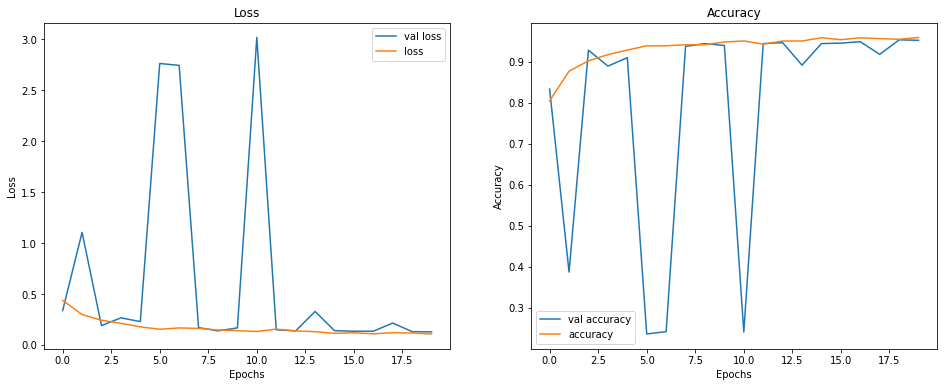

In [30]:
visualize_training_results(history_base)

In [31]:
results_test = model.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test[1]}")

20/20 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.8141
Test set results accuracy 0.8141025900840759


### Baseline + regulization

We will use L2 regulization in each layer, to reduce overfitting.
Will try different L2 coefficients to determine the best one

In [32]:
L2_list = [0.001, 0.01, 0.1, 1]

In [33]:
L2_fin = []
for L2 in L2_list:
    model2 = models.Sequential()
    model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2))) 
    model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(1, activation='sigmoid'))
    model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 0)
    results_test = model2.evaluate(test_img, test_y)
    L2_fin.append((L2, results_test[1]))
        


20/20 [==============================] - 0s 2ms/step - loss: 0.7131 - accuracy: 0.6250


In [34]:
L2_best = sorted(L2_fin, key = lambda x: x[1], reverse = True)[0][0]
print("Best L2 regulization parameter:", L2_best)

Best L2 regulization parameter: 0.01


In [35]:
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 1)


Epoch 1/20
156/156 [==============================] - 2s 8ms/step - loss: 1.8957 - accuracy: 0.7971 - val_loss: 1.6828 - val_accuracy: 0.8789
Epoch 2/20
156/156 [==============================] - 1s 7ms/step - loss: 1.6820 - accuracy: 0.8640 - val_loss: 2.7591 - val_accuracy: 0.2331
Epoch 3/20
156/156 [==============================] - 1s 7ms/step - loss: 1.5358 - accuracy: 0.8954 - val_loss: 1.5222 - val_accuracy: 0.8823
Epoch 4/20
156/156 [==============================] - 1s 8ms/step - loss: 1.4243 - accuracy: 0.9138 - val_loss: 3.8735 - val_accuracy: 0.2309
Epoch 5/20
156/156 [==============================] - 1s 7ms/step - loss: 1.4436 - accuracy: 0.8843 - val_loss: 2.2010 - val_accuracy: 0.7691
Epoch 6/20
156/156 [==============================] - 1s 7ms/step - loss: 1.2791 - accuracy: 0.9228 - val_loss: 1.2321 - val_accuracy: 0.9234
Epoch 7/20
156/156 [==============================] - 1s 7ms/step - loss: 1.2003 - accuracy: 0.9281 - val_loss: 1.4384 - val_accuracy: 0.7954
Epoch 

In [36]:
results_train = model2.evaluate(train_img, train_y)

156/156 [==============================] - 1s 4ms/step - loss: 0.9871 - accuracy: 0.8287


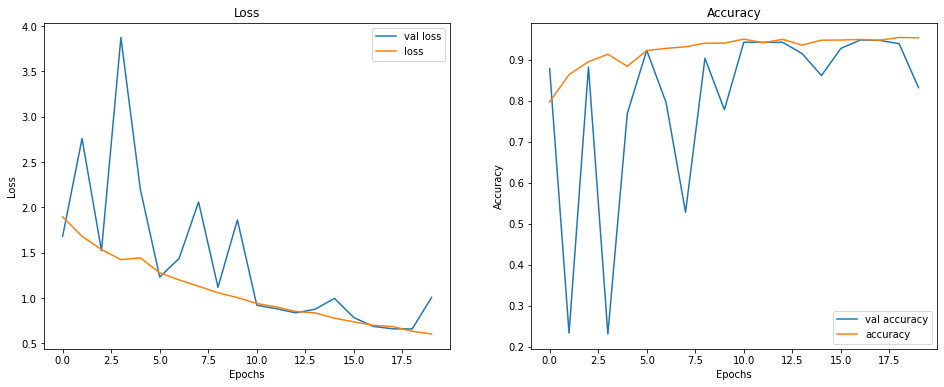

In [37]:
visualize_training_results(history_model2)

In [38]:
results_test = model2.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test[1]}")

20/20 [==============================] - 0s 4ms/step - loss: 2.1565 - accuracy: 0.6554
Test set results accuracy 0.6554487347602844


### Baseline + regulization + Dropout

In [39]:
model3 = models.Sequential()
model3.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dense(1, activation='sigmoid'))


In [40]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model3 = model3.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/20
156/156 [==============================] - 2s 9ms/step - loss: 1.9831 - accuracy: 0.7326 - val_loss: 1.9134 - val_accuracy: 0.8354
Epoch 2/20
156/156 [==============================] - 1s 8ms/step - loss: 1.7499 - accuracy: 0.8309 - val_loss: 1.5887 - val_accuracy: 0.8937
Epoch 3/20
156/156 [==============================] - 1s 8ms/step - loss: 1.5977 - accuracy: 0.8723 - val_loss: 1.5809 - val_accuracy: 0.8617
Epoch 4/20
156/156 [==============================] - 1s 8ms/step - loss: 1.4642 - accuracy: 0.9053 - val_loss: 1.5883 - val_accuracy: 0.8491
Epoch 5/20
156/156 [==============================] - 1s 8ms/step - loss: 1.3926 - accuracy: 0.9081 - val_loss: 1.4227 - val_accuracy: 0.8857
Epoch 6/20
156/156 [==============================] - 1s 8ms/step - loss: 1.2965 - accuracy: 0.9140 - val_loss: 1.9466 - val_accuracy: 0.5920
Epoch 7/20
156/156 [==============================] - 1s 8ms/step - loss: 1.2315 - accuracy: 0.9222 - val_loss: 1.1522 - val_accuracy: 0.9383
Epoch 

In [41]:
results_train3 = model3.evaluate(train_img, train_y)

156/156 [==============================] - 1s 3ms/step - loss: 0.5880 - accuracy: 0.9621


In [42]:
results_test3 = model3.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test3[1]}")

20/20 [==============================] - 0s 3ms/step - loss: 0.8936 - accuracy: 0.8622
Test set results accuracy 0.8621794581413269


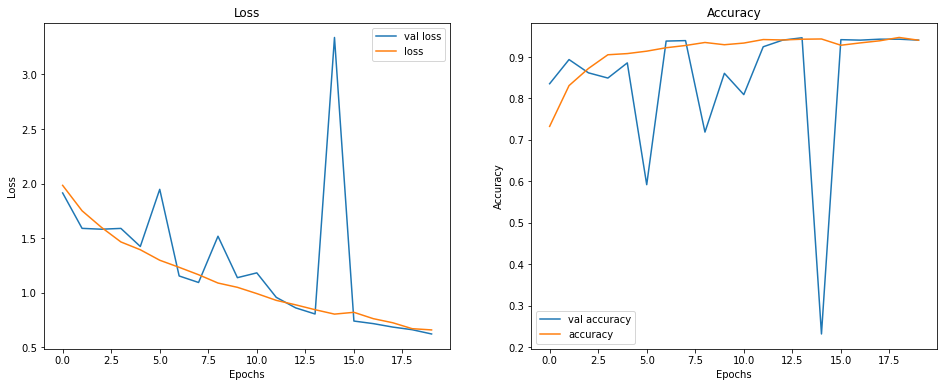

In [43]:
visualize_training_results(history_model3)

### Baseline + regulization + Dropout + Adam optimizer

In [44]:
model4 = models.Sequential()
model4.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model4 = model4.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/20
156/156 [==============================] - 2s 8ms/step - loss: 1.0910 - accuracy: 0.7860 - val_loss: 0.6053 - val_accuracy: 0.8469
Epoch 2/20
156/156 [==============================] - 1s 9ms/step - loss: 0.5252 - accuracy: 0.8894 - val_loss: 0.3949 - val_accuracy: 0.9394
Epoch 3/20
156/156 [==============================] - 1s 9ms/step - loss: 0.4057 - accuracy: 0.9228 - val_loss: 0.3787 - val_accuracy: 0.9177
Epoch 4/20
156/156 [==============================] - 2s 10ms/step - loss: 0.3794 - accuracy: 0.9206 - val_loss: 0.3032 - val_accuracy: 0.9383
Epoch 5/20
156/156 [==============================] - 1s 9ms/step - loss: 0.3417 - accuracy: 0.9285 - val_loss: 0.2763 - val_accuracy: 0.9406
Epoch 6/20
156/156 [==============================] - 1s 8ms/step - loss: 0.3380 - accuracy: 0.9321 - val_loss: 0.2781 - val_accuracy: 0.9451
Epoch 7/20
156/156 [==============================] - 1s 9ms/step - loss: 0.3187 - accuracy: 0.9335 - val_loss: 0.2661 - val_accuracy: 0.9383
Epoch

In [46]:
results_train4 = model4.evaluate(train_img, train_y)

156/156 [==============================] - 1s 3ms/step - loss: 0.2424 - accuracy: 0.9369


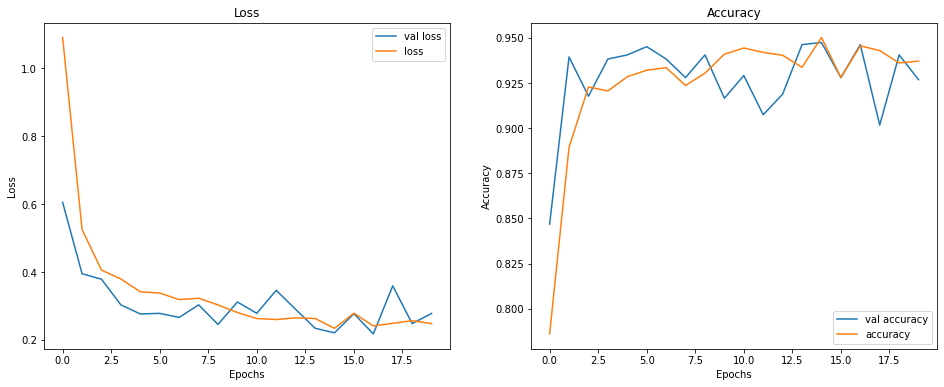

In [47]:
visualize_training_results(history_model4)

In [48]:
results_test4 = model4.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test4[1]}")

20/20 [==============================] - 0s 3ms/step - loss: 0.8767 - accuracy: 0.7516
Test set results accuracy 0.7516025900840759


### Baseline + regulization + Dropout + Adam optimizer + increased train time

In [49]:
model5 = models.Sequential()
model5.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model5.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model5.add(layers.Dense(1, activation='sigmoid'))

In [50]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model5 = model5.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=50,
                    validation_data=(val_img, val_y))

Epoch 1/50
100/100 [==============================] - 2s 12ms/step - loss: 1.2742 - accuracy: 0.7759 - val_loss: 0.7907 - val_accuracy: 0.9166
Epoch 2/50
100/100 [==============================] - 1s 10ms/step - loss: 0.6356 - accuracy: 0.8584 - val_loss: 0.4821 - val_accuracy: 0.9360
Epoch 3/50
100/100 [==============================] - 1s 10ms/step - loss: 0.5241 - accuracy: 0.8819 - val_loss: 0.4222 - val_accuracy: 0.9280
Epoch 4/50
100/100 [==============================] - 1s 10ms/step - loss: 0.3921 - accuracy: 0.9315 - val_loss: 0.3889 - val_accuracy: 0.9234
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3559 - accuracy: 0.9361 - val_loss: 0.3299 - val_accuracy: 0.9383
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3465 - accuracy: 0.9313 - val_loss: 0.2955 - val_accuracy: 0.9429
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3476 - accuracy: 0.9263 - val_loss: 0.3549 - val_accuracy: 0.9177
Ep

In [51]:
results_train5 = model5.evaluate(train_img, train_y)

156/156 [==============================] - 1s 3ms/step - loss: 0.2265 - accuracy: 0.9285


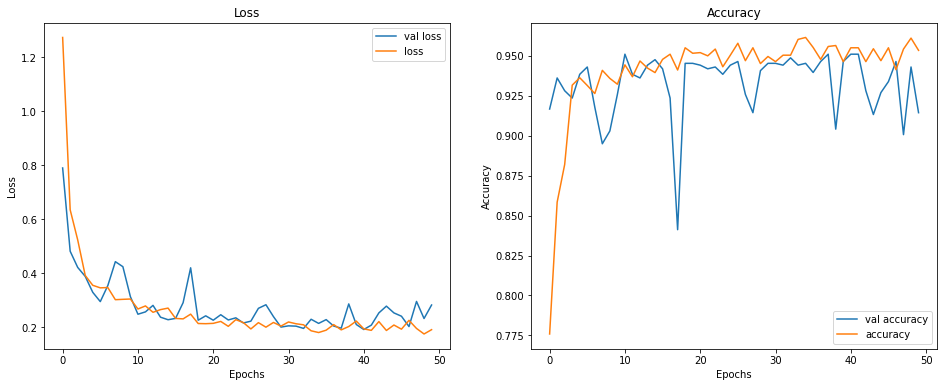

In [52]:
visualize_training_results(history_model5)

In [53]:
results_test5 = model5.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test5[1]}")

20/20 [==============================] - 0s 3ms/step - loss: 0.3749 - accuracy: 0.8734
Test set results accuracy 0.8733974099159241


### CNN_1, shape 64

In [54]:
model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(30, activation='relu'))
model_CNN.add(layers.Dense(10, activation='relu'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))

model_CNN.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [55]:
history_CNN1 = model_CNN.fit(train_images,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/25
156/156 [==============================] - 22s 138ms/step - loss: 0.5459 - accuracy: 0.7689 - val_loss: 0.5497 - val_accuracy: 0.7691
Epoch 2/25
156/156 [==============================] - 21s 135ms/step - loss: 0.4955 - accuracy: 0.7689 - val_loss: 0.6014 - val_accuracy: 0.7691
Epoch 3/25
156/156 [==============================] - 21s 134ms/step - loss: 0.4229 - accuracy: 0.7689 - val_loss: 0.3538 - val_accuracy: 0.7680
Epoch 4/25
156/156 [==============================] - 21s 132ms/step - loss: 0.3451 - accuracy: 0.8312 - val_loss: 0.3649 - val_accuracy: 0.8914
Epoch 5/25
156/156 [==============================] - 20s 130ms/step - loss: 0.3052 - accuracy: 0.8884 - val_loss: 0.3219 - val_accuracy: 0.8560
Epoch 6/25
156/156 [==============================] - 20s 130ms/step - loss: 0.2645 - accuracy: 0.9130 - val_loss: 0.2861 - val_accuracy: 0.8834
Epoch 7/25
156/156 [==============================] - 20s 128ms/step - loss: 0.2475 - accuracy: 0.9232 - val_loss: 0.2346 - val_ac

In [56]:
results_test = model_CNN.evaluate(test_images, test_y)

20/20 [==============================] - 0s 22ms/step - loss: 0.9262 - accuracy: 0.7724


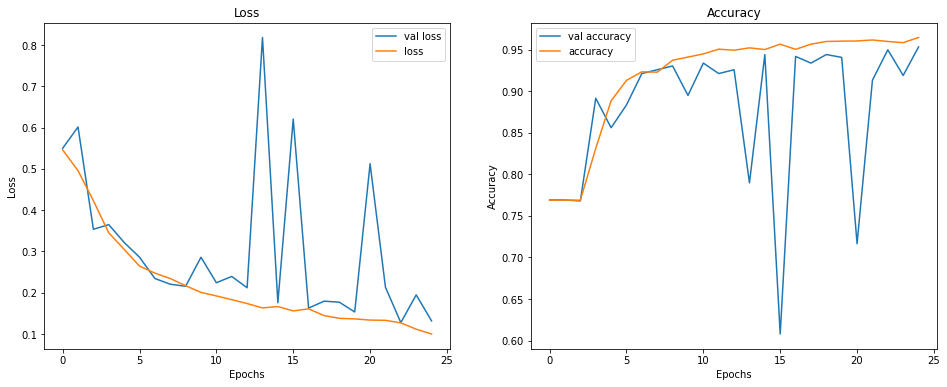

In [57]:
visualize_training_results(history_CNN1)

### CNN_2, shape 64 + dropout + regulization

In [58]:
model_CNN2 = models.Sequential()
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Flatten())
model_CNN2.add(layers.Dense(40, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [59]:
history_CNN2 = model_CNN2.fit(train_images,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/25
156/156 [==============================] - 20s 124ms/step - loss: 0.4831 - accuracy: 0.8557 - val_loss: 0.2132 - val_accuracy: 0.9486
Epoch 2/25
156/156 [==============================] - 19s 124ms/step - loss: 0.1962 - accuracy: 0.9404 - val_loss: 0.1703 - val_accuracy: 0.9497
Epoch 3/25
156/156 [==============================] - 19s 124ms/step - loss: 0.1487 - accuracy: 0.9591 - val_loss: 0.3163 - val_accuracy: 0.8800
Epoch 4/25
156/156 [==============================] - 19s 124ms/step - loss: 0.1345 - accuracy: 0.9643 - val_loss: 0.1280 - val_accuracy: 0.9634
Epoch 5/25
156/156 [==============================] - 19s 124ms/step - loss: 0.1188 - accuracy: 0.9682 - val_loss: 0.1223 - val_accuracy: 0.9611
Epoch 6/25
156/156 [==============================] - 19s 124ms/step - loss: 0.1131 - accuracy: 0.9688 - val_loss: 0.1524 - val_accuracy: 0.9509
Epoch 7/25
156/156 [==============================] - 19s 124ms/step - loss: 0.0938 - accuracy: 0.9758 - val_loss: 0.1022 - val_ac

In [60]:
results_test = model_CNN2.evaluate(test_images, test_y)

20/20 [==============================] - 0s 21ms/step - loss: 0.6372 - accuracy: 0.8590


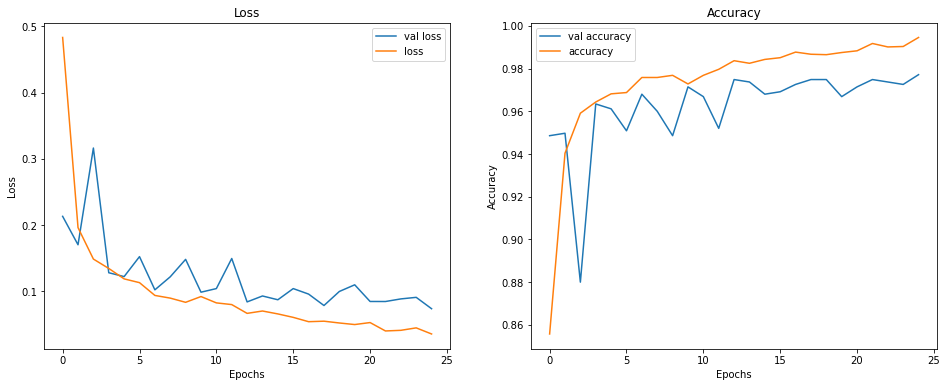

In [61]:
visualize_training_results(history_CNN2)

### CNN_3, shape 100 + dropout + regulization

In [62]:
# get all the data in the directory split/train, and reshape them
train_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(100, 100), batch_size= train_img_number)

# get all the data in the directory split/validation, and reshape them
val_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100), batch_size = val_img_number)

# get all the data in the directory split/test, and reshape them
test_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), batch_size = test_img_number) 

train_images2, train_labels2 = next(train_generator_100)
test_images2, test_labels2 = next(test_generator_100)
val_images2, val_labels2 = next(val_generator_100)




Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [63]:
test_generator_100

In [64]:
train_images2.shape

(4963, 100, 100, 3)

In [65]:
train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
val_img2 = val_images2.reshape(val_images2.shape[0], -1)

print(train_img2.shape)
print(test_img2.shape)
print(val_img2.shape)

(4963, 30000)
(624, 30000)
(875, 30000)


In [66]:
train_y2 = np.reshape(train_labels[:,0], (train_img_number,1))
test_y2 = np.reshape(test_labels[:,0], (test_img_number,1))
val_y2 = np.reshape(val_labels[:,0], (val_img_number,1))

In [67]:
model_CNN3 = models.Sequential()
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Flatten())
model_CNN3.add(layers.Dense(30, activation='relu'))
model_CNN3.add(layers.Dense(10, activation='relu'))
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [68]:
history_CNN3 = model_CNN3.fit(train_images2,
                    train_y2,
                    epochs=25,
                    batch_size=50,
                    validation_data=(val_images2, val_y2))

Epoch 1/25
100/100 [==============================] - 33s 330ms/step - loss: 0.5432 - accuracy: 0.7689 - val_loss: 0.5224 - val_accuracy: 0.7691
Epoch 2/25
100/100 [==============================] - 40s 401ms/step - loss: 0.4827 - accuracy: 0.7745 - val_loss: 0.4499 - val_accuracy: 0.7931
Epoch 3/25
100/100 [==============================] - 42s 425ms/step - loss: 0.4213 - accuracy: 0.8094 - val_loss: 0.3486 - val_accuracy: 0.8137
Epoch 4/25
100/100 [==============================] - 43s 432ms/step - loss: 0.3412 - accuracy: 0.8565 - val_loss: 0.2624 - val_accuracy: 0.8914
Epoch 5/25
100/100 [==============================] - 43s 429ms/step - loss: 0.2776 - accuracy: 0.8839 - val_loss: 0.3161 - val_accuracy: 0.8594
Epoch 6/25
100/100 [==============================] - 42s 424ms/step - loss: 0.2364 - accuracy: 0.9085 - val_loss: 0.2025 - val_accuracy: 0.9177
Epoch 7/25
100/100 [==============================] - 42s 418ms/step - loss: 0.2020 - accuracy: 0.9204 - val_loss: 0.1733 - val_ac

In [69]:
results_test = model_CNN3.evaluate(test_images2, test_y2)

20/20 [==============================] - 1s 61ms/step - loss: 0.6100 - accuracy: 0.8349


In [70]:
model_CNN4 = models.Sequential()
model_CNN4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Flatten())
model_CNN4.add(layers.Dense(30, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN4.add(layers.Dropout(0.3))
model_CNN4.add(layers.Dense(1, activation='sigmoid'))

model_CNN4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [71]:
history_CNN4 = model_CNN4.fit(train_images2,
                    train_y2,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_images2, val_y2))

Epoch 1/20
156/156 [==============================] - 42s 265ms/step - loss: 1.1190 - accuracy: 0.7689 - val_loss: 1.1264 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 42s 271ms/step - loss: 1.0030 - accuracy: 0.7894 - val_loss: 0.9611 - val_accuracy: 0.7726
Epoch 3/20
156/156 [==============================] - 42s 267ms/step - loss: 0.8604 - accuracy: 0.8481 - val_loss: 1.7133 - val_accuracy: 0.3440
Epoch 4/20
156/156 [==============================] - 41s 263ms/step - loss: 0.7491 - accuracy: 0.8908 - val_loss: 0.7265 - val_accuracy: 0.8983
Epoch 5/20
156/156 [==============================] - 41s 264ms/step - loss: 0.6815 - accuracy: 0.9134 - val_loss: 0.7580 - val_accuracy: 0.8731
Epoch 6/20
156/156 [==============================] - 41s 263ms/step - loss: 0.6127 - accuracy: 0.9327 - val_loss: 0.5934 - val_accuracy: 0.9337
Epoch 7/20
156/156 [==============================] - 39s 248ms/step - loss: 0.5724 - accuracy: 0.9432 - val_loss: 0.5649 - val_ac

In [78]:
results_test = model_CNN4.evaluate(test_images2, test_y2)

20/20 [==============================] - 1s 30ms/step - loss: 0.8992 - accuracy: 0.8029


##### argumented CNN 100

In [194]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.2, 
                                   horizontal_flip=False)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100),
        batch_size = 32,
        class_mode='binary')

# get all the data in the directory split/train (542 images), and reshape them
train_generator_arg_100 = train_datagen2.flow_from_directory(
        train_folder, target_size=(100, 100),
        batch_size = 64, class_mode='binary')


Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.


In [195]:
train_images_100_arg, train_labels_100_arg = next(train_generator_arg_100)
test_images_100_arg, test_labels_100_arg = next(test_generator_arg_100)
val_images_100_arg, val_labels_100_arg = next(val_generator_arg_100)

In [196]:
model_CNN6 = models.Sequential()
model_CNN6.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Flatten())
model_CNN6.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN6.add(layers.Dropout(0.3))
model_CNN6.add(layers.Dense(1, activation='sigmoid'))

model_CNN6.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [ ]:
history_CNN6 = model_CNN6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=20, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

Epoch 1/20
 8/25 [========>.....................] - ETA: 32s - loss: 1.6224 - accuracy: 0.7285

### 250 resolution, argumented

In [166]:
train_datagen2 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.2, 
                                   horizontal_flip=False)

In [167]:
test_generator3 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(250, 250), 
        batch_size = 64,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
val_generator3 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(250, 250),
        batch_size = 32,
        class_mode='binary')

# get all the data in the directory split/train (542 images), and reshape them
train_generator3 = train_datagen2.flow_from_directory(train_folder, target_size=(250, 250), batch_size = 32, class_mode='binary')

        

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.


In [175]:
train_images3, train_labels3 = next(train_generator3)
test_images3, test_labels3 = next(test_generator3)
val_images3, val_labels3 = next(val_generator3)

In [172]:
model_CNN5 = models.Sequential()
model_CNN5.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(250 ,250, 3)))
model_CNN5.add(layers.MaxPooling2D((2, 2)))

model_CNN5.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN5.add(layers.MaxPooling2D((2, 2)))

model_CNN5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN5.add(layers.MaxPooling2D((2, 2)))

model_CNN5.add(layers.Flatten())
model_CNN5.add(layers.Dense(30, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN5.add(layers.Dropout(0.3))
model_CNN5.add(layers.Dense(1, activation='sigmoid'))

model_CNN5.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [173]:
history_CNN5 = model_CNN5.fit_generator(train_generator3, 
                                steps_per_epoch=25, 
                                epochs=60, 
                                validation_data=val_generator3, 
                                validation_steps=25)

Epoch 1/60
25/25 [==============================] - 77s 3s/step - loss: 0.7755 - accuracy: 0.7663 - val_loss: 0.5485 - val_accuracy: 0.8225
Epoch 2/60
25/25 [==============================] - 74s 3s/step - loss: 0.5028 - accuracy: 0.7977 - val_loss: 0.5711 - val_accuracy: 0.7850
Epoch 3/60
25/25 [==============================] - 72s 3s/step - loss: 0.4835 - accuracy: 0.7964 - val_loss: 0.5398 - val_accuracy: 0.7738
Epoch 4/60
25/25 [==============================] - 74s 3s/step - loss: 0.5036 - accuracy: 0.7713 - val_loss: 0.4931 - val_accuracy: 0.7563
Epoch 5/60
25/25 [==============================] - 75s 3s/step - loss: 0.4349 - accuracy: 0.8250 - val_loss: 0.4680 - val_accuracy: 0.8575
Epoch 6/60
25/25 [==============================] - 73s 3s/step - loss: 0.4605 - accuracy: 0.8418 - val_loss: 0.5154 - val_accuracy: 0.8575
Epoch 7/60
25/25 [==============================] - 75s 3s/step - loss: 0.4665 - accuracy: 0.8000 - val_loss: 0.3617 - val_accuracy: 0.8788
Epoch 8/60
25/25 [==

25/25 [==============================] - 75s 3s/step - loss: 0.3010 - accuracy: 0.9013 - val_loss: 0.2990 - val_accuracy: 0.9175
Epoch 60/60
25/25 [==============================] - 73s 3s/step - loss: 0.2864 - accuracy: 0.8900 - val_loss: 0.2629 - val_accuracy: 0.9137


In [182]:
test_generator3 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(250, 250), 
        batch_size = 624,
        class_mode='binary') 
test_images3, test_labels3 = next(test_generator3)

results_test = model_CNN5.evaluate(test_images3, test_y3)

Found 624 images belonging to 2 classes.
20/20 [==============================] - 5s 227ms/step - loss: 1.7951 - accuracy: 0.4247


### CNN_3, shape 299 + dropout + regulization


In [125]:
# get all the data in the directory split/train, and reshape them
train_generator_299 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(299, 299), batch_size= train_img_number)

# get all the data in the directory split/validation, and reshape them
val_generator_299 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(299, 299), batch_size = val_img_number)

# get all the data in the directory split/test, and reshape them
test_generator_299 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(299, 299), batch_size = test_img_number) 

train_images3, train_labels3 = next(train_generator_299)
test_images3, test_labels3 = next(test_generator_299)
val_images3, val_labels3 = next(val_generator_299)

train_img3 = train_images3.reshape(train_images3.shape[0], -1)
test_img3 = test_images3.reshape(test_images3.shape[0], -1)
val_img3 = val_images3.reshape(val_images3.shape[0], -1)

print(train_img3.shape)
print(test_img3.shape)
print(val_img3.shape)



Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
(4963, 268203)
(624, 268203)
(875, 268203)


In [126]:
train_y3 = np.reshape(train_labels3[:,0], (train_img_number,1))
test_y3 = np.reshape(test_labels3[:,0], (test_img_number,1))
val_y3 = np.reshape(val_labels3[:,0], (val_img_number,1))

In [ ]:
from keras.applications.xception import Xception
cnn_base = Xception(weights='imagenet',  
                 input_shape=(299, 299, 3))



In [127]:
model_X = models.Sequential()
model_X.add(cnn_base)
model_X.add(layers.Flatten())
model_X.add(layers.Dense(128, activation='relu'))
model_X.add(layers.Dropout(0.4))
model_X.add(layers.Dense(1, activation='sigmoid'))
cnn_base.trainable = False


In [128]:
model_X.compile(loss='binary_crossentropy',
               optimizer="SGD",
               metrics=['accuracy'])


In [129]:
history_CNN5 = model_X.fit(train_images3,
                    train_y3,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images3, val_y3))

Epoch 1/30
156/156 [==============================] - 3786s 24s/step - loss: 0.6230 - accuracy: 0.7608 - val_loss: 0.5765 - val_accuracy: 0.7691
Epoch 2/30
156/156 [==============================] - 6901s 44s/step - loss: 0.5565 - accuracy: 0.7689 - val_loss: 0.5439 - val_accuracy: 0.7691
Epoch 3/30
156/156 [==============================] - 6791s 44s/step - loss: 0.5375 - accuracy: 0.7689 - val_loss: 0.5334 - val_accuracy: 0.7691
Epoch 4/30
156/156 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7689 

KeyboardInterrupt: 

In [97]:
cnn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_31 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_30[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_31[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_34 (A

In [104]:
results_test = history_CNN5.evaluate(test_images3, test_y3)

NameError: name 'history_CNN5' is not defined

### Data Augmentation

In [121]:
model_X2 = models.Sequential()
model_X2.add(cnn_base)
model_X2.add(layers.Flatten())
model_X2.add(layers.Dense(128, activation='relu'))
model_X2.add(layers.Dropout(0.4))
model_X2.add(layers.Dense(1, activation='sigmoid'))
cnn_base.trainable = False
model_X2.compile(loss='binary_crossentropy',
               optimizer="SGD",
               metrics=['accuracy'])


In [136]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=60, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

In [137]:
test_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(299, 299), 
        batch_size = 64,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
val_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(299, 299),
        batch_size = 32,
        class_mode='binary')

# get all the data in the directory split/train (542 images), and reshape them
train_generator2 = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(299, 299), 
        batch_size = 32, 
        class_mode='binary')

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.


In [124]:
history_X2 = model_X2.fit_generator(train_generator2, 
                                steps_per_epoch=25, 
                                epochs=30, 
                                validation_data=val_generator2, 
                                validation_steps=25)

Epoch 1/30
25/25 [==============================] - 301s 12s/step - loss: 0.6815 - accuracy: 0.7050 - val_loss: 0.6687 - val_accuracy: 0.7650
Epoch 2/30
25/25 [==============================] - 280s 11s/step - loss: 0.6592 - accuracy: 0.7575 - val_loss: 0.6483 - val_accuracy: 0.7688
Epoch 3/30
25/25 [==============================] - 267s 11s/step - loss: 0.6403 - accuracy: 0.7588 - val_loss: 0.6331 - val_accuracy: 0.7613
Epoch 4/30
25/25 [==============================] - 262s 11s/step - loss: 0.6230 - accuracy: 0.7665 - val_loss: 0.6186 - val_accuracy: 0.7625
Epoch 5/30
25/25 [==============================] - 265s 11s/step - loss: 0.6075 - accuracy: 0.7700 - val_loss: 0.6040 - val_accuracy: 0.7675
Epoch 6/30
25/25 [==============================] - 274s 11s/step - loss: 0.5944 - accuracy: 0.7700 - val_loss: 0.5942 - val_accuracy: 0.7650
Epoch 7/30
25/25 [==============================] - 288s 12s/step - loss: 0.5751 - accuracy: 0.7850 - val_loss: 0.5849 - val_accuracy: 0.7638
Epoch 

In [131]:
results_test = model_X2.evaluate(test_images3, test_y3)

20/20 [==============================] - 105s 5s/step - loss: 0.9879 - accuracy: 0.3750


# Conclusion
---
For our finalized model we used LinearRegression because of the following reasons: 
1) It is easy to interprete.

2) It have good recall compared to the other models, without much sacrifice in precision. 


Overall, this data tells us that injuries during car crashes can be predicted and we can see tha major factors that influence it. These modeling results correspond to our observations during data exploration phase